# Analyzing differences in forecasts between neighborhoods

## Import necessary modules

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

In [2]:
# function to select a few rows of data, 
# convert to a Pandas dataframe, and transpose

def preview(df, n=3, sample=False, sample_frac=0.01):
    if sample == True:
        return pd.DataFrame(df.sample(False, sample_frac).take(n), columns=df.columns)
    else:
        return pd.DataFrame(df.take(n), columns=df.columns)

## Open files

We'll reread the 2015 data and using Spark, group it per neighborhood.

In [3]:
fn = 'gs://metis_bucket_av/data/uber-tlc-foil-response/uber-trip-data/uber-janjune-15-loc.csv'
df15 = spark.read.csv(fn, header=True)

In [4]:
num_rows_df15 = df15.count()
print('{:,} rows'.format(num_rows_df15))

14,264,110 rows


In [5]:
df15.printSchema()

root
 |-- Dispatching_base_num: string (nullable = true)
 |-- Pickup_date: string (nullable = true)
 |-- locationID: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Loc: string (nullable = true)



In [6]:
preview(df15, 5)

,Dispatching_base_num,Pickup_date,locationID,Borough,Loc
0,B02617,2015-05-17 09:47:00,141,Manhattan,Upper East Side
1,B02617,2015-05-17 09:47:00,65,Brooklyn,Downtown Brooklyn
2,B02617,2015-05-17 09:47:00,100,Manhattan,Midtown
3,B02617,2015-05-17 09:47:00,80,Brooklyn,Williamsburg
4,B02617,2015-05-17 09:47:00,90,Manhattan,Flatiron District


### Casting data types

We can convert data types in the spark dataframe above to conver the pickup_date column to datetime. But first, we'll extract the borough and loc columns so we can use it as a neighborhood/borough mapping dataframe if needed.

In [7]:
boroughs = df15.select('Borough', 'Loc').toPandas()

In [8]:
from collections import defaultdict
neighborhoods = defaultdict(list)
for b in boroughs['Borough'].unique():
    neighs = boroughs[boroughs['Borough'] == b].Loc.unique()
    neighborhoods[b] = neighs

In [9]:
del boroughs

In [10]:
import pyspark.sql.types as pst
import pyspark.sql.functions as psf

In [11]:
df15 = df15.select(
            psf.to_timestamp(df15['Pickup_date'], 'yyyy-MM-dd HH:mm:ss').alias('dt'),
            df15.Loc)

df15.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- Loc: string (nullable = true)



### Pivoting Spark DataFrame  
We can pivot the pyspark dataframe to get a timeseries for each neighborhood. The resulting dataframe will have a column per neighborhood, with rows as the hourly uber pickups.

In [12]:
# convert pivoted dataframe to pandas

ts15 = (df15
 .groupBy(psf.date_format('dt', 'yyyy-MM-dd HH').alias('ds'))
 .pivot('Loc').count().orderBy('ds').toPandas())

In [13]:
ts15['ds'] = pd.to_datetime(ts15['ds'])
ts15.set_index('ds', inplace=True)
ts15.head(5)

,Arden Heights,Arverne,Astoria,Bath Beach,Battery Park City,Bay Ridge,Bay Terrace,Bayside,Bedford-Stuyvesant,Bellerose,...,West Farms,West Village,Westchester Square,Westerleigh,Whitestone,Williamsbridge,Williamsburg,Windsor Terrace,Woodhaven,Woodside
ds,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,NaN,NaN,74.0,6.0,51.0,21.0,3.0,4.0,79.0,1.0,...,4.0,394,2.0,2.0,1.0,NaN,327,6.0,4.0,7.0
2015-01-01 01:00:00,NaN,NaN,50.0,2.0,15.0,13.0,5.0,3.0,82.0,2.0,...,1.0,356,5.0,1.0,1.0,2.0,325,16.0,7.0,3.0
2015-01-01 02:00:00,1.0,NaN,58.0,NaN,23.0,32.0,NaN,10.0,101.0,1.0,...,2.0,425,5.0,NaN,4.0,2.0,431,8.0,12.0,9.0
2015-01-01 03:00:00,NaN,NaN,66.0,2.0,23.0,30.0,1.0,4.0,121.0,3.0,...,5.0,359,2.0,1.0,3.0,2.0,464,8.0,10.0,11.0
2015-01-01 04:00:00,NaN,NaN,48.0,NaN,6.0,15.0,NaN,4.0,76.0,NaN,...,4.0,170,2.0,NaN,2.0,2.0,286,5.0,5.0,8.0


Next, we'll check how many neighborhoods actually have significant data. 

In [14]:
# sum up pickups in each neighborhoods
pickups_for_neighborhoods = []
for n in ts15.columns:
    pickups_for_neighborhoods.append(ts15[n].sum())

In [15]:
# check how many have on average at least 1 pickup per hour
len([x for x in pickups_for_neighborhoods if x>4334])

124

In [16]:
# only keep those columns in the main dataframe
ts15_columns = ts15.columns
for c in ts15_columns:
    if ts15[c].sum() < 4334:
        ts15.drop(labels=[c], axis=1, inplace=True)

### Split train/test

For 2015, there is data present for 6 months, Jan-June. It is split up as follows:
* **Training set:** January to May (5 months)
* **Test set:** June (1 month)

In [17]:
ts15_train = ts15[:'2015-05'].copy(deep = True)
ts15_test = ts15['2015-06'].copy(deep = True)

In [18]:
del ts15

## Modelling

### Comparison Functions  
We'll use the functions below to plot forecasts from various models and calculate their RMSE errors.

In [19]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_actual, y_predicted, print_val=True):
    """
    Args:
    -----
    y_actual - Array of actual target values
    y_predicted - Array of predicted target values
    print_val - If `True` (default), RMSE will be
                printed. Otherwise, it will be 
                returned.
    """
    err = sqrt(mean_squared_error(y_actual, y_predicted))
    if print_val:
        print('RMSE: {:,.2f}'.format(err))
    else:
        return err
    
    
def percent_error(y_actual, y_predicted, print_val=True):
    """
    percent_error is RMSE divided by sum of actual
    rides
    
    Args:
    -----
    y_actual - Array of actual target values
    y_predicted - Array of predicted target values
    print_val - If `True` (default), percent error will be
                printed. Otherwise, it will be 
                returned.
    """
    err = rmse(y_actual, y_predicted, print_val=False)
    err = float(err)/np.mean(y_actual)
    # err = np.mean(np.abs(np.subtract(list(actuals), list(pred.yhat))))/np.mean(actuals)
    
    if print_val:
        print('RMSE/daily_mean: {:,.2%}'.format(err))
    else:
        return err
    
    
def plot_forecast(actual, pred, title='Actual vs Forecast', 
                  xlabel='Date', ylabel='Number of Uber Pickups', 
                  grid=True, figsize=(10, 5)):
    
    if len(actual) != len(pred):
        return_str = 'Unequal lengths error: '
        return_str += '({} actual, '.format(len(actual))
        return_str += '{} forecast)'.format(len(pred))
        return return_str
    
    plt.figure(figsize=figsize)
    plt.plot(actual, label='Actual')
    plt.plot(actual.index, pred, label='Predicted', c='r')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(actual.index.date[::24], 
               actual.index.day[::24])
    plt.xlim(min(actual.index.date), max(actual.index.date))
    plt.legend(loc=0)
    plt.grid(True)

### Prophet - Neighborhood Level

For the next model, we'll use Facebook's open source forecasting package named [Prophet](https://facebook.github.io/prophet/). Its method calls are similar to sklearn, when it comes to fitting and predicting. It's a quick way to generate forecasts without too many extraneous features.

In [20]:
from fbprophet import Prophet

Prophet requires a very specifically named dataframe as input. Instead of modifying our existing timeseries for 2015, we'll create a new one for Prophet.

In [21]:
def get_prophet_df(location, df):
    '''Returns a dataframe for a particular neighborhood
    in the format needed by prophet'''
    
    rdf = pd.DataFrame(df[location])
    rdf['ds'] = rdf.index
    rdf['y'] = rdf[location]
    rdf.reset_index(drop=True, inplace=True)
    rdf.drop(labels=[location], axis=1, inplace=True)
    rdf.fillna(value=0)
    
    return rdf

#### Loop through locations for a model of each neighborhood

In [22]:
def prophet_forecast(location, fit_df, fc_pd, extra_reg=False, 
                     extra_reg_names = [], future_df=[]):
    """Returns a pandas dataframe with predictions
    and a datetime index for the specified location. 
    For extra regressors `extra_reg == True`, fit_df 
    and future_df must be provided according to the 
    Prophet documentation."""
    
    # fit
    m = Prophet(yearly_seasonality=False)
    if extra_reg == False:
        m.fit(get_prophet_df(location, fit_df))
    else:
        for er in extra_reg_names:
            m.add_regressor(er)
        m.fit(fit_df)
    
    # forecast
    if len(future_df) == 0:
        future = m.make_future_dataframe(periods=fc_pd, freq='H')
    else:
        future = future_df
        
    forecast = m.predict(future)
    pred = pd.DataFrame(forecast.yhat[-1*fc_pd:])
    
    return pred

In [23]:
%%capture --no-stdout --no-display
y_actual = {}
y_pred = {}
rmses = {}
per_err = {}
fc_pd = 24*30
num_neighborhoods = len(ts15_train.columns)

for i, n in enumerate(ts15_train.columns):
    
    print('{:>3}/{}'.format(i+1, num_neighborhoods), 
          n, ' - starting', end=', ')
    
    # actual uber pickups
    actual = ts15_test[:fc_pd][n]
    actual.fillna(value=0, inplace=True)
    y_actual[n] = list(actual)
    
    # prediction values
    print('forecasting', end=', ')
    pred = prophet_forecast(n, ts15_train, fc_pd)
    y_pred[n] = list(pred.yhat)
    
    # accuracy metrics
    print('calculating RMSE', end='\n')
    rmses[n] = rmse(y_actual[n], y_pred[n], print_val=False)
    per_err[n] = percent_error(y_actual[n], y_pred[n], print_val=False)

  1/124 Astoria  - starting, forecasting, calculating RMSE
  2/124 Battery Park City  - starting, forecasting, calculating RMSE
  3/124 Bay Ridge  - starting, forecasting, calculating RMSE
  4/124 Bayside  - starting, forecasting, calculating RMSE
  5/124 Bedford-Stuyvesant  - starting, forecasting, calculating RMSE
  6/124 Belmont  - starting, forecasting, calculating RMSE
  7/124 Bensonhurst  - starting, forecasting, calculating RMSE
  8/124 Boerum Hill  - starting, forecasting, calculating RMSE
  9/124 Borough Park  - starting, forecasting, calculating RMSE
 10/124 Brighton Beach  - starting, forecasting, calculating RMSE
 11/124 Brooklyn Heights  - starting, forecasting, calculating RMSE
 12/124 Brownsville  - starting, forecasting, calculating RMSE
 13/124 Bushwick  - starting, forecasting, calculating RMSE
 14/124 Canarsie  - starting, forecasting, calculating RMSE
 15/124 Carroll Gardens  - starting, forecasting, calculating RMSE
 16/124 Castle Hill  - starting, forecasting, cal

RMSE: 94.36
RMSE/mean(daily): 33.46%


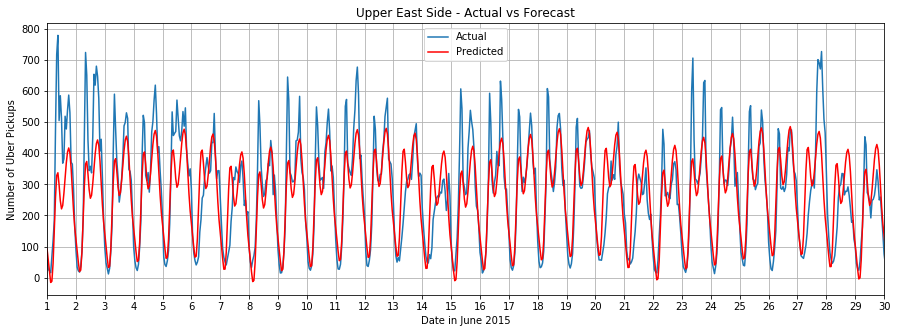

In [24]:
# check one random location's forecast

location = np.random.choice(ts15_train.columns)
plt_actual = pd.DataFrame(y_actual[location], index=ts15_test.index)

plot_forecast(plt_actual, y_pred[location], 
              title = location+' - Actual vs Forecast', 
              xlabel = 'Date in June 2015', figsize=(15, 5))

print('RMSE: {:.2f}'.format(rmses[location]))
print('RMSE/mean(daily): {:.2%}'.format(per_err[location]))

We'll take a sum of all the RMSE values we have from this timeseries modeling. With future models, we'll do the same and compare the change in RMSE values to determine if our model has improved or gotten worse. 

In [25]:
print('Total RMSE: Prophet Model (No Extra Regressors)')
print('{:.2f}'.format(np.sum(list(rmses.values()))))

Total RMSE: Prophet Model (No Extra Regressors)
1556.59


#### Writing to CSV  
To save the efforts of all this modeling, we'll write our forecasts and actual values to CSV files. 

In [229]:
# first, we write out the training and test sets
ts15_train.to_csv('uber_pickups_train.csv')
ts15_test.to_csv('uber_pickups_test.csv')

In [241]:
# create DF of prophet results
prophet_preds = pd.DataFrame(y_pred, index=ts15_test.index)
prophet_stats = pd.DataFrame(data=[rmses, per_err], 
                             index=['rmse', 'rmse_over_mean'])

# write out the prophet results & stats
prophet_preds.to_csv('prophet_0reg_preds.csv')
prophet_stats.to_csv('prophet_0reg_stats.csv')

### Prophet - Extra Regressors

With prophet, we can add extra regressors on the same timeseries to add additional features to our model. One such feature we can add is categorize all the popular nightlife hours in NYC. 

#### Adding weekend nights

In [26]:
def add_nighttime_rush(ds):
    """Returns a 1 if provided `ds` date is within 
    the defined nightlife hours. Otherwise returns
    a 0. Nightlife hours are defined as:
    * Thu 10 PM to Fri 1 AM
    * Fri 10 PM to Sat 2 AM
    * Sat 10 PM to Sun 2 AM"""
    date = pd.to_datetime(ds)
    if (date.weekday() == 3) & (date.hour > 21):
        return 1
    elif (date.weekday() == 4) & (date.hour < 2):
        return 1
    elif (date.weekday() == 4) & (date.hour > 21):
        return 1
    elif (date.weekday() == 5) & (date.hour < 3):
        return 1
    elif (date.weekday() == 5) & (date.hour > 21):
        return 1
    elif (date.weekday() == 6) & (date.hour < 4):
        return 1
    else:
        return 0

In [28]:
%%capture --no-stdout --no-display
y_pred_nt = {}
rmses_nt = {}
per_err_nt = {}
fc_pd = 24*30
num_neighborhoods = len(ts15_train.columns)

# initialize prophet with a random neighborhood
m = Prophet(yearly_seasonality=False)
m.fit(get_prophet_df('Midtown', ts15_train))

for i, n in enumerate(ts15_train.columns):
    
    print('{:>3}/{}'.format(i+1, num_neighborhoods), 
          n, ' - starting', end=', ')
    
    # create prediction df
    pred_df = get_prophet_df(n, ts15_train)
    pred_df['night_life'] = pred_df['ds'].apply(add_nighttime_rush)
    future_df = m.make_future_dataframe(periods=fc_pd, freq='H')
    future_df['night_life'] = future_df['ds'].apply(add_nighttime_rush)
    
    # forecast
    print('forecasting', end=', ')
    pred = prophet_forecast(n, pred_df, fc_pd, 
                            extra_reg=True, 
                            extra_reg_names=['night_life'],
                            future_df=future_df)
    y_pred_nt[n] = list(pred.yhat)
    
    # accuracy metrics
    print('calculating RMSE', end='\n')
    rmses_nt[n] = rmse(y_actual[n], y_pred_nt[n], print_val=False)
    per_err_nt[n] = percent_error(y_actual[n], y_pred_nt[n], print_val=False)

  1/124 Astoria  - starting, forecasting, calculating RMSE
  2/124 Battery Park City  - starting, forecasting, calculating RMSE
  3/124 Bay Ridge  - starting, forecasting, calculating RMSE
  4/124 Bayside  - starting, forecasting, calculating RMSE
  5/124 Bedford-Stuyvesant  - starting, forecasting, calculating RMSE
  6/124 Belmont  - starting, forecasting, calculating RMSE
  7/124 Bensonhurst  - starting, forecasting, calculating RMSE
  8/124 Boerum Hill  - starting, forecasting, calculating RMSE
  9/124 Borough Park  - starting, forecasting, calculating RMSE
 10/124 Brighton Beach  - starting, forecasting, calculating RMSE
 11/124 Brooklyn Heights  - starting, forecasting, calculating RMSE
 12/124 Brownsville  - starting, forecasting, calculating RMSE
 13/124 Bushwick  - starting, forecasting, calculating RMSE
 14/124 Canarsie  - starting, forecasting, calculating RMSE
 15/124 Carroll Gardens  - starting, forecasting, calculating RMSE
 16/124 Castle Hill  - starting, forecasting, cal

RMSE: 91.57
RMSE/mean(daily): 32.47%


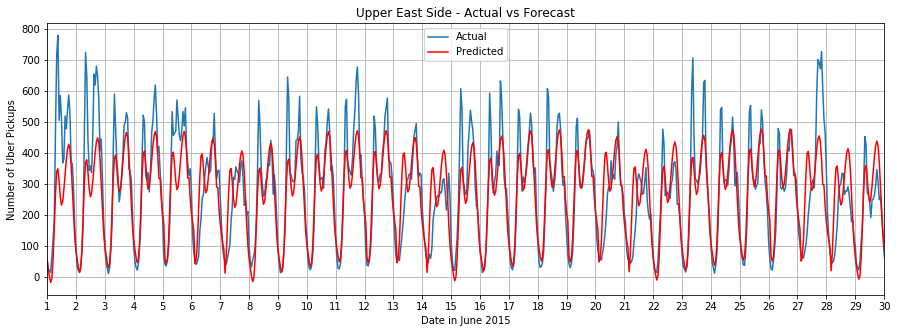

In [29]:
# we'll check the same forecast again

plt_actual = pd.DataFrame(y_actual[location], index=ts15_test.index)

plot_forecast(plt_actual, y_pred_nt[location], 
              title = location+' - Actual vs Forecast', 
              xlabel = 'Date in June 2015', figsize=(15, 5))

print('RMSE: {:.2f}'.format(rmses_nt[location]))
print('RMSE/mean(daily): {:.2%}'.format(per_err_nt[location]))

The chart shows a better match between actual and predicted than before. Let's take a look at the sum of RMSEs. 

In [31]:
print('Total RMSE: Prophet Model (with nightlife hours)')
print('{:.2f}'.format(np.sum(list(rmses_nt.values()))))

Total RMSE: Prophet Model (with nightlife hours)
1460.29


Not bad - definitely lower than our previous total RMSE of 1556. Perhaps we can add more regressors to lower this even more.

##### Write to CSV

In [268]:
# create DF of prophet results
prophet_preds = pd.DataFrame(y_pred_nt, index=ts15_test.index)
prophet_stats = pd.DataFrame(data=[rmses_nt, per_err_nt], 
                             index=['rmse', 'rmse_over_mean'])

# write out the prophet results & stats
prophet_preds.to_csv('prophet_1reg_preds.csv')
prophet_stats.to_csv('prophet_1reg_stats.csv')

##### Read from CSV

In [84]:
# read in existing data from csv backups because 
# the kernel had crashed at this point

prophet_preds = pd.read_csv('prophet_1reg_preds.csv')    # previous prophet predictions
ts15_train = pd.read_csv('uber_pickups_train.csv')       # training data
ts15_test = pd.read_csv('uber_pickups_test.csv')         # testing data
for df in [prophet_preds, ts15_train, ts15_test]:        # set datetime indices
    df.set_index(pd.to_datetime(df['ds']), inplace=True)
    df.drop(labels=['ds'], axis=1, inplace=True)

prophet_stats = pd.read_csv('prophet_1reg_stats.csv', index_col=0)

In [136]:
# write in info from dataframe to dictionaries

y_actual = {}
y_pred = {}
rmses = {}
per_err = {}
fc_pd = 24*30

for c in prophet_preds.columns:
    y_actual[c] = list(ts15_test[c])
    y_pred[c] = list(prophet_preds[c])
    rmses[c] = prophet_stats[c].loc['rmse']
    per_err[c] =prophet_stats[c].loc['rmse_over_mean']

#### Adding bicycling data

In [32]:
cb = pd.read_csv('citibike_hourly.csv')
cb.set_index(pd.to_datetime(cb['date']), inplace=True)
cb.drop(labels=['date'], axis=1, inplace=True)
cb.fillna(value=0, inplace=True)

In [33]:
# drop neighborhoods we don't have Uber data for
for c in cb.columns:
    if c not in ts15_train.columns:
        print(c)
        cb.drop(labels=[c], axis=1, inplace=True)

DUMBO
Hell's Kitchen
NoHo
Nolita
Tribeca


In [34]:
print(len(cb.columns), 'neighborhoods')

33 neighborhoods


We only have bicycling data for 33 of our neighborhoods. For those neighborhoods, we'll add the bicycling data as an extra regressor and then compare with the previous results to see if the forecasts improve.

In [37]:
%%capture --no-stdout --no-display

# dictionaries for data with bicycling regressor
y_pred_cb = {}
rmses_cb = {}
per_err_cb = {}
num_neighborhoods = len(cb.columns)

# initialize prophet with a random neighborhood
# to get some future functions to work right
m = Prophet(yearly_seasonality=False)
m.fit(get_prophet_df('Midtown', ts15_train))

# loop through neighborhoods with bicycling data
for i, n in enumerate(cb.columns):
    
    print('{:>3}/{}'.format(i+1, num_neighborhoods), 
          n, ' - starting', end=', ')

    # create prediction df
    pred_df = get_prophet_df(n, ts15_train)
    pred_df['night_life'] = pred_df['ds'].apply(add_nighttime_rush)
    pred_df = pred_df.merge(cb[[n]], how='left', left_on='ds', right_index=True)
    pred_df.rename(columns={n: 'bicycling'}, inplace=True)
    pred_df.fillna(value=0, inplace=True)
    
    future_df = m.make_future_dataframe(periods=fc_pd, freq='H')
    future_df['night_life'] = future_df['ds'].apply(add_nighttime_rush)
    future_df = future_df.merge(cb[[n]], how='left', left_on='ds', right_index=True)
    future_df.rename(columns={n: 'bicycling'}, inplace=True)
    future_df.fillna(value=0, inplace=True)
    
    # forecast
    print('forecasting', end=', ')
    pred = prophet_forecast(n, pred_df, fc_pd, 
                            extra_reg=True, 
                            extra_reg_names=['night_life', 'bicycling'],
                            future_df=future_df)
    y_pred_cb[n] = list(pred.yhat)
    
    # accuracy metrics
    print('calculating RMSE', end='\n')
    rmses_cb[n] = rmse(y_actual[n], y_pred_cb[n], print_val=False)
    per_err_cb[n] = percent_error(y_actual[n], y_pred_cb[n], print_val=False)

  1/33 Battery Park City  - starting, forecasting, calculating RMSE
  2/33 Bedford-Stuyvesant  - starting, forecasting, calculating RMSE
  3/33 Boerum Hill  - starting, forecasting, calculating RMSE
  4/33 Brooklyn Heights  - starting, forecasting, calculating RMSE
  5/33 Central Park  - starting, forecasting, calculating RMSE
  6/33 Chelsea  - starting, forecasting, calculating RMSE
  7/33 Chinatown  - starting, forecasting, calculating RMSE
  8/33 Civic Center  - starting, forecasting, calculating RMSE
  9/33 Clinton Hill  - starting, forecasting, calculating RMSE
 10/33 Columbia St  - starting, forecasting, calculating RMSE
 11/33 Downtown Brooklyn  - starting, forecasting, calculating RMSE
 12/33 East Village  - starting, forecasting, calculating RMSE
 13/33 Financial District  - starting, forecasting, calculating RMSE
 14/33 Flatiron District  - starting, forecasting, calculating RMSE
 15/33 Fort Greene  - starting, forecasting, calculating RMSE
 16/33 Gramercy  - starting, foreca

RMSE: 92.72
RMSE/mean(daily): 32.88%


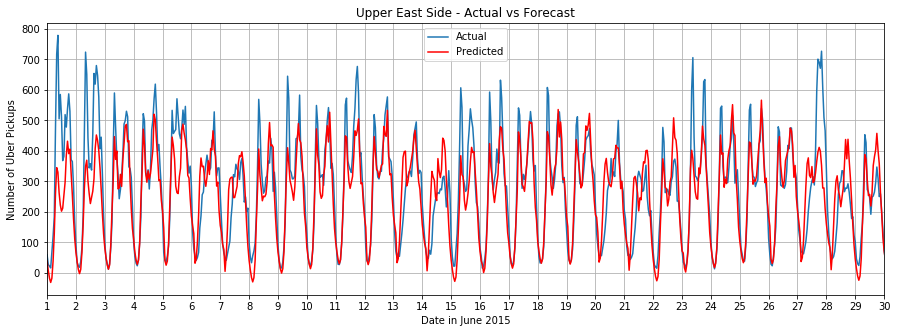

In [38]:
# we'll check the same forecast again

plt_actual = pd.DataFrame(y_actual[location], index=ts15_test.index)

plot_forecast(plt_actual, y_pred_cb[location], 
              title = location+' - Actual vs Forecast', 
              xlabel = 'Date in June 2015', figsize=(15, 5))

print('RMSE: {:.2f}'.format(rmses_cb[location]))
print('RMSE/mean(daily): {:.2%}'.format(per_err_cb[location]))

##### Visualizing gain from bicycle data

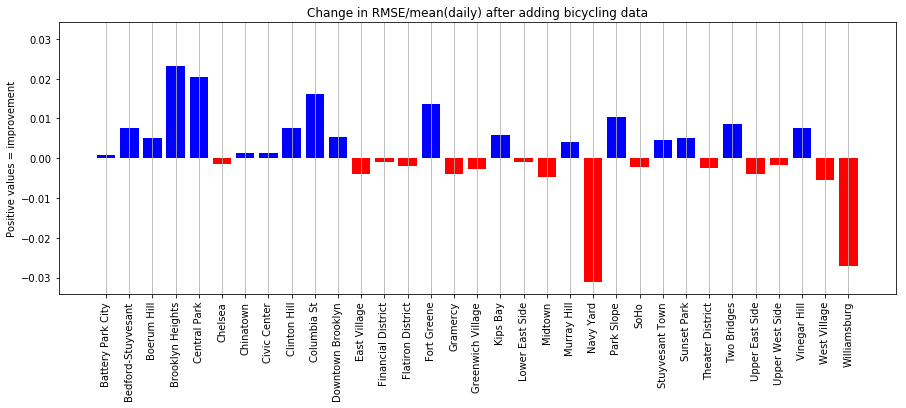

In [61]:
# plot net gain/loss in RMSE by adding bicycling

cb_neighs = []
plt_per_err = []
plt_per_err_cb = []
plt_per_err_reduction = []
plt_per_err_red_dic = defaultdict(float)
plt_colors = []

for c in cb.columns:
    cb_neighs.append(c)
    plt_per_err.append(per_err_nt[c])
    plt_per_err_cb.append(per_err_cb[c])
    plt_per_err_reduction.append(per_err_nt[c] - per_err_cb[c])
    plt_per_err_red_dic[c] = per_err_nt[c] - per_err_cb[c]
    color_val = 'r' if (per_err_nt[c] - per_err_cb[c] < 0) else 'b'
    plt_colors.append(color_val)
    
plt.figure(figsize=(15, 5))
plt.bar(cb_neighs, plt_per_err_reduction, color=plt_colors)
plt.title('Change in RMSE/mean(daily) after adding bicycling data')
plt.ylabel('Positive values = improvement')
plt.xticks(cb_neighs, cb_neighs, rotation='vertical')
y_lim = np.max(np.abs(plt_per_err_reduction))
plt.ylim((-1.1*y_lim, 1.1*y_lim))
plt.grid(axis='x')

The chart above shows that adding bicycling data:
* slightly helps most neighborhoods
* slightly hurts some neighborhoods  

We can sum all gains and losses to see if it's overall a better forecasting model.

In [50]:
print('Percent improvement: {:.2%}'.format(np.sum(plt_per_err_reduction)))

Percent improvement: 5.44%


Yes, overall, adding bicycling data helps!

In [65]:
# keep best results

y_pred_best = {}
rmses_best = {}
per_err_best = {}

# go through all neighborhoods
for c in ts15_train.columns:
    
    # update with nighttime data
    y_pred_best[c] = y_pred_nt[c]
    rmses_best[c] = rmses_nt[c]
    per_err_best[c] = per_err_nt[c]
    
    # check to see if we have bicycling data
    if c in cb.columns:
        
        # did bicycling data help?
        if plt_per_err_red_dic[c]>=0:
            y_pred_best[c] = y_pred_cb[c]
            rmses_best[c] = rmses_cb[c]
            per_err_best[c] = per_err_cb[c]

In [66]:
print('Total RMSE: Prophet Model (with nightlife and bicycling)')
print('{:.2f}'.format(np.sum(list(rmses_best.values()))))

Total RMSE: Prophet Model (with nightlife and bicycling)
1455.92


##### Writing to csv

In [67]:
# save to csv
# create DF of prophet results
prophet_preds = pd.DataFrame(y_pred_best, index=ts15_test.index)
prophet_stats = pd.DataFrame(data=[rmses_best, per_err_best], 
                             index=['rmse', 'rmse_over_mean'])

# write out the prophet results & stats
prophet_preds.to_csv('prophet_2reg_preds.csv')
prophet_stats.to_csv('prophet_2reg_stats.csv')

##### Ranking the forecasts

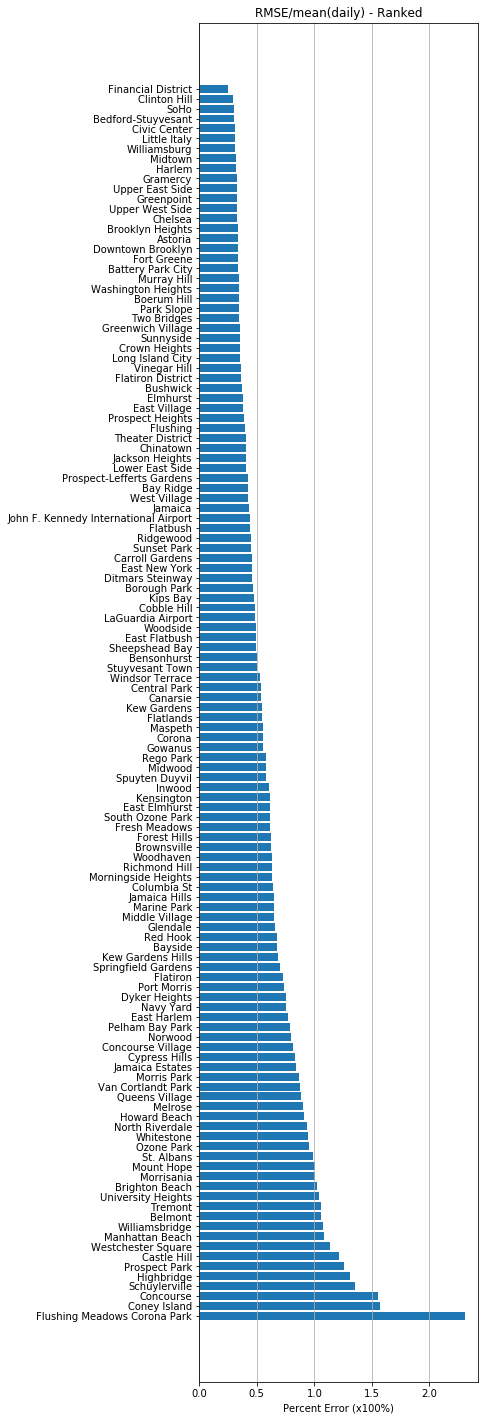

In [69]:
neighs_sorted = sorted(per_err_best, key=per_err_best.get, reverse=True)
per_err_sorted = [per_err_best[n] for n in neighs_sorted]

plt.figure(figsize=(5, 25))
plt.barh(neighs_sorted, per_err_sorted)
plt.title('RMSE/mean(daily) - Ranked')
plt.xlabel('Percent Error (x100%)')
plt.grid(axis='x');

#### Adding MTA data

In [71]:
# open MTA file from GCS
fn = 'gs://metis_bucket_av/data/nyc_subway_with_loc.csv'
mta = spark.read.csv(fn, header=True)

# create a series of neighborhoods and 
# number of train stations in each
mta = mta.toPandas()
station_counts = (mta
                  .groupby('loc')['Division']
                  .count()
                  .sort_values(ascending=False))

In the absence of actual train schedules, we'll estimate the frequency of trains based on turnstile data analysis from a previous project. We'll have two profiles of subway entrances vs time:
1. For business, recreational, and commercial neighborhoods
2. For residential neighborhoods

In [72]:
# create a list of business district or 
# non-residential neighborhoods
def get_simulated_mta_data(loc, df):
    """Returns a dataframe with simulated MTA train frequency
    based on turnstile entry data"""
    
    businessy_ns = ['Upper West Side', 'Upper East Side',
                    'Midtown', 'Theater District', 'Murray Hill', 
                    'Chelsea', 'West Village', 'Greenwich Village', 
                    'Gramercy', 'East Village', 'Lower East Side', 
                    'SoHo', 'Civic Center', 'Financial District', 
                    'Williamsburg', 'Clinton Hill']
    
    businessy_data = {0:20, 1:20, 2:20, 3:10, 4:7, 5:7, 6:7, 7:20, 
                      8:42, 9:42, 10:42, 11:42, 12:60, 13:60, 14:60, 
                      15:80, 16:110, 17:110, 18:110, 19:100, 20:62, 
                      21:62, 22:62, 23:50}
    
    residential_data = {0:5, 1:5, 2:5, 3:5, 4:80, 5:80, 6:80, 7:80, 
                        8:110, 9:110, 10:110, 11:110, 12:60, 13:60, 
                        14:60, 15:60, 16:35, 17:35, 18:35, 
                        19:35, 20:10, 21:10, 22:10, 23:10}
    
    if loc in businessy_ns:
        df['mta'] = df['ds'].map(lambda x: businessy_data[x.hour]*station_counts[loc])
    else:
        df['mta'] = df['ds'].map(lambda x: residential_data[x.hour]*station_counts[loc])
        
    return df

In [79]:
%%capture --no-stdout --no-display

# dictionaries for data with MTA regressor
y_pred_mta = {}
rmses_mta = {}
per_err_mta = {}
neighs_in_stations_and_uber = list(set(station_counts.index) & set(ts15_train.columns))
num_neighborhoods = len(neighs_in_stations_and_uber)

# initialize prophet with a random neighborhood
m = Prophet(yearly_seasonality=False)
m.fit(get_prophet_df('Midtown', ts15_train))

# loop through neighborhoods with MTA data
for i, n in enumerate(neighs_in_stations_and_uber):
    
    print('{:>3}/{}'.format(i+1, num_neighborhoods), 
          n, ' - starting', end=', ')

    # create prediction df
    pred_df = get_prophet_df(n, ts15_train)
    pred_df['night_life'] = pred_df['ds'].apply(add_nighttime_rush)
    
    # only for neighborhoods where bicycling data helped
    if n in plt_per_err_red_dic.keys():
        pred_df = pred_df.merge(cb[[n]], how='left', left_on='ds', right_index=True)
        pred_df.rename(columns={n: 'bicycling'}, inplace=True)
        pred_df.fillna(value=0, inplace=True)
        
    pred_df = get_simulated_mta_data(n, pred_df)
    
    # create future df
    future_df = m.make_future_dataframe(periods=fc_pd, freq='H')
    future_df['night_life'] = future_df['ds'].apply(add_nighttime_rush)
    
    # only for neighborhoods where bicycling data helped
    if n in plt_per_err_red_dic.keys():
        future_df = future_df.merge(cb[[n]], how='left', left_on='ds', right_index=True)
        future_df.rename(columns={n: 'bicycling'}, inplace=True)
        future_df.fillna(value=0, inplace=True)
        
    future_df = get_simulated_mta_data(n, future_df)

    # forecast
    print('forecasting', end=', ')
    if n in plt_per_err_red_dic.keys():
        pred = prophet_forecast(n, pred_df, fc_pd, 
                            extra_reg=True, 
                            extra_reg_names=['night_life', 'bicycling', 'mta'],
                            future_df=future_df)
    else:
        pred = prophet_forecast(n, pred_df, fc_pd, 
                            extra_reg=True, 
                            extra_reg_names=['night_life', 'mta'],
                            future_df=future_df)
        
    y_pred_mta[n] = list(pred.yhat)
    
    # accuracy metrics
    print('calculating RMSE', end='\n')
    rmses_mta[n] = rmse(y_actual[n], y_pred_mta[n], print_val=False)
    per_err_mta[n] = percent_error(y_actual[n], y_pred_mta[n], print_val=False)

  1/81 Canarsie  - starting, forecasting, calculating RMSE
  2/81 East Village  - starting, forecasting, calculating RMSE
  3/81 Financial District  - starting, forecasting, calculating RMSE
  4/81 Jamaica  - starting, forecasting, calculating RMSE
  5/81 Carroll Gardens  - starting, forecasting, calculating RMSE
  6/81 Morris Park  - starting, forecasting, calculating RMSE
  7/81 Gowanus  - starting, forecasting, calculating RMSE
  8/81 Gramercy  - starting, forecasting, calculating RMSE
  9/81 Mount Hope  - starting, forecasting, calculating RMSE
 10/81 Theater District  - starting, forecasting, calculating RMSE
 11/81 Borough Park  - starting, forecasting, calculating RMSE
 12/81 Williamsburg  - starting, forecasting, calculating RMSE
 13/81 West Village  - starting, forecasting, calculating RMSE
 14/81 Richmond Hill  - starting, forecasting, calculating RMSE
 15/81 Brownsville  - starting, forecasting, calculating RMSE
 16/81 Woodhaven  - starting, forecasting, calculating RMSE
 17

RMSE: 23.35
RMSE/mean(daily): 25.60%


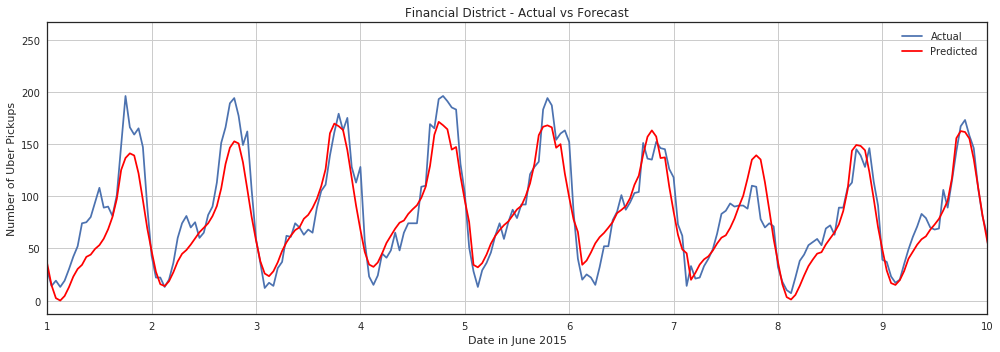

In [451]:
# we'll check the same forecast again

plt_actual = pd.DataFrame(y_actual[location], index=ts15_test.index)

plot_forecast(plt_actual, y_pred_mta[location], 
              title = location+' - Actual vs Forecast', 
              xlabel = 'Date in June 2015', figsize=(15, 5))

plt.xlim(pd.to_datetime('2015-06-01'), pd.to_datetime('2015-06-10'))

print('RMSE: {:.2f}'.format(rmses_mta[location]))
print('RMSE/mean(daily): {:.2%}'.format(per_err_mta[location]))

In [92]:
# calculate RMSE values for neighborhoods with MTA data
with_mta = []
without_mta = [0]

for k in rmses_mta:
    with_mta.append(rmses_mta[k])
    without_mta.append(rmses[k])
    
# compare with RMSE without MTA data
print(np.mean(with_mta), np.mean(without_mta))

15.106886587233795 16.022810107701243


In [94]:
# overwrite data with new MTA predictions

for c in neighs_in_stations_and_uber:
    if rmses_best[c] > rmses_mta[c]:
        rmses_best[c] = rmses_mta[c]
        y_pred_best[c] = y_pred_mta[c]
        per_err_best[c] = per_err_mta[c]

In [95]:
print('Total RMSE: Prophet (with nightlife, bicycling, & MTA)')
print('{:.2f}'.format(np.sum(list(rmses_best.values()))))

Total RMSE: Prophet (with nightlife, bicycling, & MTA)
1452.74


##### Writing to csv

In [96]:
# save to csv
# create DF of prophet results
prophet_preds = pd.DataFrame(y_pred_best, index=ts15_test.index)
prophet_stats = pd.DataFrame(data=[rmses_best, per_err_best], 
                             index=['rmse', 'rmse_over_mean'])

# write out the prophet results & stats
prophet_preds.to_csv('prophet_3reg_preds.csv')
prophet_stats.to_csv('prophet_3reg_stats.csv')

mta.to_csv('mta_station_info.csv')
station_counts.to_csv('station_counts.csv')

In [108]:
# the previous station_counts file actually counts all entrances & exits
# that information is also important so we'll create a new file for 
# unique stations per neighborhood
actual_station_counts = mta.groupby('loc')['Station Location'].nunique().sort_values(ascending=False)
actual_station_counts.to_csv('actual_station_counts.csv')

##### Removing negative values from forecast

We know that demand cannot be less than zero - so we can make all negative values in our forecast equal to zero.

In [321]:
y_pred_best_no_neg = {}
rmses_best_no_neg = {}
per_err_best_no_neg = {}

for c in ts15_test.columns:
    predictions = []
    rmse_values = []
    per_err_values = []
    
    for p in y_pred_best[c]:
        if p < 0:
            predictions.append(0)
        else:
            predictions.append(p)
    
    y_pred_best_no_neg[c] = predictions
    rmses_best_no_neg[c] = rmse(y_actual[c], y_pred_best_no_neg[c], print_val=False)
    per_err_best_no_neg[c] = percent_error(y_actual[c], y_pred_best_no_neg[c], print_val=False)

In [322]:
print('{:.2f}'.format(np.sum(list(rmses_best.values()))))

1452.74


In [323]:
print('{:.2f}'.format(np.sum(list(rmses_best_no_neg.values()))))

1451.07


## Tableau Exports

### Counting total rides by neighborhood

For a Tableau visualization, I will make a dataframe that contains all rides (from the training set) per neighborhood.

In [274]:
ts15_neighborhoods = []
ts15_total_pickups = []
for c in ts15_train.columns:
    ts15_neighborhoods.append(c)
    ts15_total_pickups.append(np.sum(ts15_train[c]))

In [276]:
sum_pickups_train = pd.DataFrame({'neighborhood':ts15_neighborhoods, 'sum_pickups':ts15_total_pickups})

In [278]:
sum_pickups_train.head()

,neighborhood,sum_pickups
0,Astoria,98485.0
1,Battery Park City,112527.0
2,Bay Ridge,28341.0
3,Bayside,6916.0
4,Bedford-Stuyvesant,119186.0


We'll also have to get all our prediction vs actual data into a special format for Tableau.

In [ ]:
# save to csv
# create DF of prophet results
prophet_preds = pd.DataFrame(y_pred_best, index=ts15_test.index)
prophet_stats = pd.DataFrame(data=[rmses_best, per_err_best], 
                             index=['rmse', 'rmse_over_mean'])

# write out the prophet results & stats
prophet_preds.to_csv('prophet_3reg_preds.csv')
prophet_stats.to_csv('prophet_3reg_stats.csv')

mta.to_csv('mta_station_info.csv')
station_counts.to_csv('station_counts.csv')

In [240]:
# create a df of forecast vs test data

test_index = ts15_test.index
tableau_df = pd.DataFrame(columns=['Neighborhood', 'Datetime', 'Forecast', 
                                   'Actual', 'RMSE', 'Percent_Error'])

for loc in ['Midtown', 'Chelsea', 'Williamsburg']:
    temp_df = pd.DataFrame(columns=['Neighborhood', 'Datetime', 'Forecast', 
                                    'Actual', 'RMSE', 'Percent_Error'])
    temp_df['Neighborhood'] = [loc]*len(ts15_test)
    temp_df['Forecast'] = pd.Series(y_pred_best[loc])
    temp_df['Datetime'] = test_index
    temp_df['Actual'] = pd.Series(y_actual[loc])
    temp_df['RMSE'] = pd.Series([rmses_best[loc]]*len(ts15_test))
    temp_df['Percent_Error'] = pd.Series([per_err_best[loc]]*len(ts15_test))
    
    tableau_df = pd.concat([tableau_df, temp_df], ignore_index=True)

In [236]:
# create a df of historical training data

train_index = ts15_train.index
tableau_df_h = pd.DataFrame(columns=['Neighborhood', 'Datetime', 'Historical'])

for loc in ts15_train.columns:
    temp_df = pd.DataFrame(columns=['Neighborhood', 'Datetime', 'Historical'])
    temp_df['Neighborhood'] = [loc]*len(ts15_train)
    temp_df['Datetime'] = train_index
    temp_df['Historical'] = get_prophet_df(loc, ts15_train)['y']
    
    tableau_df_h = pd.concat([tableau_df_h, temp_df], ignore_index=True)

### Weekday-grouped historical data

In [237]:
# create a df of historical training data
# with only values for each weekday rather
# than hourly

def get_df_weekdays(df):
    
    df = pd.DataFrame(df)
    df['weekday'] = df.index
    df['weekday'] = df['weekday'].apply(lambda x: x.weekday())
    
    return df.groupby('weekday').sum().reset_index()

tableau_df_mini = pd.DataFrame(columns=['Neighborhood', 'Weekday', 'Historical'])

for loc in ts15_train.columns:
    temp_df = pd.DataFrame(columns=['Neighborhood', 'Weekday', 'Historical'])
    temp_df['Neighborhood'] = [loc]*7
    temp_df[['Weekday', 'Historical']] = get_df_weekdays(ts15_train[loc])
    
    tableau_df_mini = pd.concat([tableau_df_mini, temp_df], ignore_index=True)

In [241]:
tableau_df.to_csv('tableau_forecasts_mini.csv')
tableau_df_h.to_csv('tableau_historical.csv')

In [239]:
tableau_df_mini.to_csv('tableau_historical_weekday.csv')

Unfortunately, Tableau was not a fan of the separate data sources above. So we'll make a new dataframe that contains historical data grouped by weekday and forecast data for only one week and write that to one CSV file.

In [257]:
temp_df = get_df_weekdays(ts15_train['Midtown'])
tableau_hist_dates = pd.to_datetime(['2015-05-03 0:00', '2015-05-04 0:00', '2015-05-05 0:00', 
                                     '2015-05-06 0:00', '2015-05-07 0:00', '2015-05-08 0:00', 
                                     '2015-05-09 0:00'])
temp_df['weekday'] = tableau_hist_dates

In [344]:
tableau_hist_dates = pd.to_datetime(['2015-05-03 0:00', '2015-05-04 0:00', '2015-05-05 0:00', 
                                     '2015-05-06 0:00', '2015-05-07 0:00', '2015-05-08 0:00', 
                                     '2015-05-09 0:00'])

def get_df_weekdays_with_may_dates(df):
    
    loc = df.name
    order_cols = ['hood', 'datetime', 'historical', 'forecast', 
                  'actual', 'rmse', 'per_err']
    
    df = pd.DataFrame(df)
    df['datetime'] = df.index
    df['datetime'] = df['datetime'].apply(lambda x: x.weekday())
    df = df.groupby('datetime').sum().reset_index()
    
    df['datetime'] = tableau_hist_dates
    df['hood'] = [loc]*7
    df.rename(columns={loc: 'historical'}, inplace=True)
    
    df['forecast'] = np.zeros(7)
    df['actual'] = np.zeros(7)
    df['rmse'] = np.zeros(7)
    df['per_err'] = np.zeros(7)
    
    return df[order_cols]

def get_one_week_forecast(df):
    
    loc = df.name
    order_cols = ['hood', 'datetime', 'historical', 'forecast', 
                  'actual', 'rmse', 'per_err']
    
    df = pd.DataFrame(df)
    df['hood'] = [loc]*len(df)
    df['forecast'] = y_pred_best_no_neg[loc]
    df['rmse'] = rmses_best_no_neg[loc]
    df['per_err'] = per_err_best_no_neg[loc]
    df['historical'] = np.zeros(len(df))
    
    df = df[:'2015-06-07']
    df.reset_index(inplace=True)
    df.rename(columns={'ds':'datetime', loc:'actual'}, inplace=True)
    
    return df[order_cols]

### One dataframe for historical & forecast data

In [352]:
tableau_take2 = pd.DataFrame(columns=['hood', 'datetime', 'historical', 
                                      'forecast','actual', 'rmse', 'per_err'])
for c in ts15_test.columns:
    print(c, end=', ')
    hist_df = get_df_weekdays_with_may_dates(ts15_train[c])
    forecast_df = get_one_week_forecast(ts15_test[c])
    tableau_take2 = pd.concat([tableau_take2, hist_df, forecast_df])
    
print(',,, DONE!')

Astoria, Battery Park City, Bay Ridge, Bayside, Bedford-Stuyvesant, Belmont, Bensonhurst, Boerum Hill, Borough Park, Brighton Beach, Brooklyn Heights, Brownsville, Bushwick, Canarsie, Carroll Gardens, Castle Hill, Central Park, Chelsea, Chinatown, Civic Center, Clinton Hill, Cobble Hill, Columbia St, Concourse, Concourse Village, Coney Island, Corona, Crown Heights, Cypress Hills, Ditmars Steinway, Downtown Brooklyn, Dyker Heights, East Elmhurst, East Flatbush, East Harlem, East New York, East Village, Elmhurst, Financial District, Flatbush, Flatiron, Flatiron District, Flatlands, Flushing, Flushing Meadows Corona Park, Forest Hills, Fort Greene, Fresh Meadows, Glendale, Gowanus, Gramercy, Greenpoint, Greenwich Village, Harlem, Highbridge, Howard Beach, Inwood, Jackson Heights, Jamaica, Jamaica Estates, Jamaica Hills, John F. Kennedy International Airport, Kensington, Kew Gardens, Kew Gardens Hills, Kips Bay, LaGuardia Airport, Little Italy, Long Island City, Lower East Side, Manhattan

In [354]:
tableau_take2.to_csv('tableau_take2.csv')

In [365]:
location = 'Financial District'
print('RMSE: {:.2f}'.format(rmses_best_no_neg[location]))
print('RMSE/mean(daily): {:.2%}'.format(per_err_best_no_neg[location]))

RMSE: 23.19
RMSE/mean(daily): 25.42%


In [364]:
np.abs(np.sum(y_pred_best_no_neg[location]) - np.sum(y_actual[location]))/np.sum(y_actual[location])

0.13456798429168781

In [374]:
np.sum(y_actual['Astoria'])

25362.0

In [383]:
sum_all_error = 0
for i in rmses_best_no_neg:
    sum_all_error += rmses_best_no_neg[i]
    
print(sum_all_error)

1451.0741870081083


In [401]:
sum_all_actuals = np.zeros(len(ts15_test))
sum_all_preds = np.zeros(len(ts15_test))

for c in ts15_test.columns:
    sum_all_actuals = sum_all_actuals + y_actual[c]
    sum_all_preds = sum_all_preds + y_pred_best_no_neg[c]

In [403]:
sum_all_actuals.sum()

2790996.0

In [409]:
rmse(sum_all_actuals, sum_all_preds)
percent_error(sum_all_actuals, sum_all_preds)

RMSE: 861.36
RMSE/daily_mean: 22.22%


### Gains with Geographic Data

In [429]:
list_of_neighborhoods = []
list_of_gains = []
colors = []

for c in ts15_test.columns:
    list_of_neighborhoods.append(c)
    gain = per_err[c] - per_err_best_no_neg[c]
    list_of_gains.append(gain)
    if gain < 0:
        colors.append('r')
    else:
        colors.append('navy')

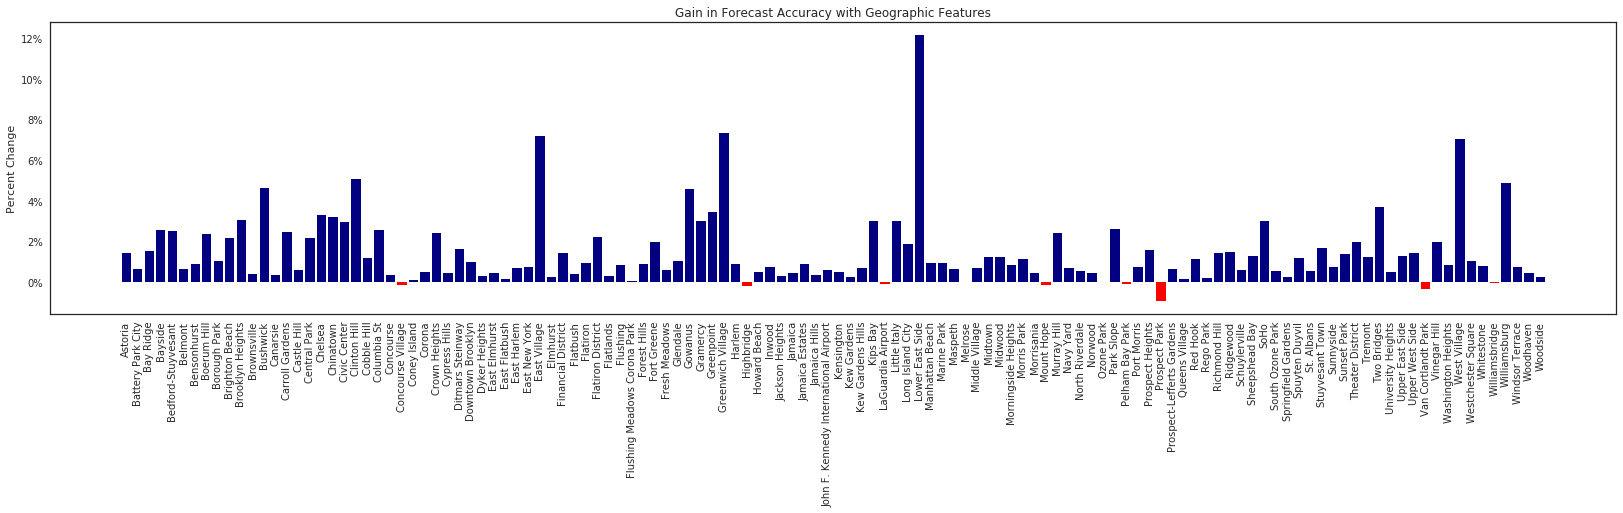

In [438]:
y_tick_locs = [0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12]
y_ticks = ['{:.0%}'.format(x) for x in y_tick_locs]

plt.style.use('seaborn-white')
plt.figure(figsize=(25,5))
plt.bar(range(len(list_of_neighborhoods)), list_of_gains, color=colors)
plt.title('Gain in Forecast Accuracy with Geographic Features')
plt.ylabel('Percent Change')
plt.xticks(range(len(list_of_neighborhoods)), list_of_neighborhoods, rotation='vertical');
plt.yticks(y_tick_locs, y_ticks);
# plt.savefig('overall_gain.png', dpi=300);

In [442]:
gains_df = pd.DataFrame({'neighborhoods':list_of_neighborhoods, 'gain':list_of_gains})
gains_df.to_csv('geographic_gains.csv')